Take in a graph of SNP by SNP and use diagonal to build a graph.

In [163]:
## imports
import numpy as np
import networkx as nx
import scipy.stats as stats
import pandas as pd
import os
from bed_reader import open_bed
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.embedding import LouvainEmbedding
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from networkx.algorithms import community
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency
from scipy.sparse import diags

In [164]:
def get_diagonal(df, width) : # convert SNPxSNP matrix as a result of cramer's to diagonal
    mid = df[df.shape(0)]
    arr = []
    result = np.empty(arr)
    for i in df:
        for j in df.T:
            if abs((i - j)) > width:
                result.append(j)

    return result

In [165]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'
## read bed and select values
bed = open_bed(file_name)
print(bed.shape)
values = bed.read(index=np.s_[0:71,0:71])
print(values.shape)
values = np.array(values)

(488377, 26806)
(71, 71)


SAMPLE build Cramer's correlation matrix
note: Do not use, use SNPcorrelation.ipynb

In [166]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  
  return stat/(obs*mini)

In [167]:
import warnings ## temporarily hide NaN division warnings
warnings.filterwarnings("ignore")

rows= []

for var1 in values:
  col = []
  for var2 in values.T:
    cramers =cramers_V(var1, var2) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results)

labels = []
for i in range(len(rows)):
    labels.append(i)

df.columns = labels
df.index = labels

df

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.00,NaN,0.07,0.03,0.02,0.00,0.02,NaN,0.01,0.04,...,0.02,0.20,0.02,0.06,0.09,0.03,0.03,NaN,0.03,0.00
1,0.00,NaN,0.12,0.01,0.06,0.07,0.04,NaN,0.00,0.02,...,0.02,0.07,0.02,0.15,0.04,0.07,0.04,NaN,0.01,0.01
2,0.00,NaN,0.01,0.01,0.16,0.24,0.06,NaN,0.04,0.02,...,0.01,0.11,0.02,0.01,0.07,0.04,0.02,NaN,0.05,0.01
3,0.03,NaN,0.01,0.01,0.11,0.13,0.05,NaN,0.03,0.10,...,0.09,0.12,0.01,0.08,0.07,0.06,0.02,NaN,0.04,0.02
4,0.01,NaN,0.03,0.01,0.04,0.07,0.02,NaN,0.01,0.02,...,0.03,0.05,0.02,0.03,0.04,0.02,0.01,NaN,0.02,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.01,NaN,0.02,0.01,0.07,0.09,0.05,NaN,0.04,0.05,...,0.03,0.08,0.04,0.01,0.04,0.07,0.02,NaN,0.02,0.02
67,0.02,NaN,0.03,0.02,0.08,0.16,0.02,NaN,0.02,0.00,...,0.00,0.10,0.01,0.01,0.05,0.04,0.01,NaN,0.09,0.01
68,0.00,NaN,0.07,0.02,0.08,0.17,0.06,NaN,0.00,0.02,...,0.03,0.14,0.01,0.06,0.04,0.02,0.01,NaN,0.02,0.00
69,0.01,NaN,0.06,0.07,0.05,0.04,0.03,NaN,0.03,0.06,...,0.03,0.05,0.03,0.19,0.06,0.02,0.06,NaN,0.01,0.01


Build graph

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.    nan 0.   ... 0.   0.   0.  ]
 [0.   0.   0.01 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ...  nan 0.   0.  ]
 [0.   0.   0.   ... 0.   0.01 0.  ]
 [0.   0.   0.   ... 0.   0.   0.02]]
(71, 71)
[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan  1.         ...         nan -0.01428571
  -0.01428571]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan -0.01428571 ...         nan  1.
  -0.01428571]
 [        nan         nan -0.01428571 ...         nan -0.01428571
   1.        ]]
(71, 2)


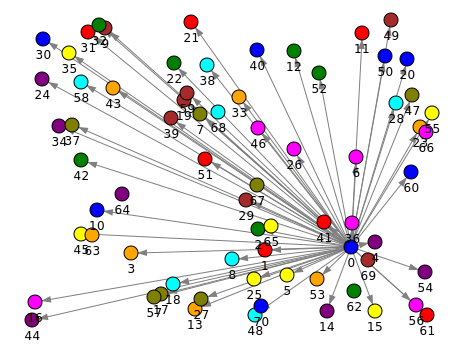

In [168]:
# build graph

offset = 0

# get diagonals
dfMatrix = sparse.csr_matrix(df) # convert data frame to a sparse matrix
diagonals = dfMatrix.diagonal(offset) # get diagonal of matrix
diagArray = diags(diagonals, offset).toarray() # convert diagonal into a square matrix with diagonal filled
print(diagArray)

# correlate diagonals
cor = np.corrcoef(diagArray) # build correlation array for diagonal (pearson's)
print(cor.shape)
print(cor)
corMatrix = sparse.csr_matrix(cor) # convert array to sparse matrix [WILL ALWAYS BE SQUARE]

# create adjacency matrix 
G = nx.Graph(corMatrix) # create graph from sparse data
adjacency = nx.adjacency_matrix(G) # create Adjacency matrix
adjacencyMatrix = sparse.csr_matrix(adjacency) # convert array to sparse row matrix form

## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(adjacencyMatrix)
print(embedding.shape)
degrees = adjacency.dot(np.ones(adjacency.shape[0]))
#seeds = list(np.argsort(-degrees)[:10])
image = svg_graph(adjacencyMatrix, position=embedding, labels=labels, names=np.arange(len(labels)), name_position='below', display_node_weight=True, scores=degrees)

#show graph
SVG(image)

In [169]:
"""
====================
Biadjacency matrices
====================
"""
import itertools

import networkx as nx
from networkx.convert_matrix import _generate_weighted_edges

__all__ = ["biadjacency_matrix"]


def biadjacency_matrix(
    G, row_order, column_order=None, dtype=None, weight="weight", format="csr"
):
    r"""Returns the biadjacency matrix of the bipartite graph G.

    Let `G = (U, V, E)` be a bipartite graph with node sets
    `U = u_{1},...,u_{r}` and `V = v_{1},...,v_{s}`. The biadjacency
    matrix [1]_ is the `r` x `s` matrix `B` in which `b_{i,j} = 1`
    if, and only if, `(u_i, v_j) \in E`. If the parameter `weight` is
    not `None` and matches the name of an edge attribute, its value is
    used instead of 1.

    Parameters
    ----------
    G : graph
       A NetworkX graph

    row_order : list of nodes
       The rows of the matrix are ordered according to the list of nodes.

    column_order : list, optional
       The columns of the matrix are ordered according to the list of nodes.
       If column_order is None, then the ordering of columns is arbitrary.

    dtype : NumPy data-type, optional
        A valid NumPy dtype used to initialize the array. If None, then the
        NumPy default is used.

    weight : string or None, optional (default='weight')
       The edge data key used to provide each value in the matrix.
       If None, then each edge has weight 1.

    format : str in {'bsr', 'csr', 'csc', 'coo', 'lil', 'dia', 'dok'}
        The type of the matrix to be returned (default 'csr').  For
        some algorithms different implementations of sparse matrices
        can perform better.  See [2]_ for details.

    Returns
    -------
    M : SciPy sparse array
        Biadjacency matrix representation of the bipartite graph G.

    Notes
    -----
    No attempt is made to check that the input graph is bipartite.

    For directed bipartite graphs only successors are considered as neighbors.
    To obtain an adjacency matrix with ones (or weight values) for both
    predecessors and successors you have to generate two biadjacency matrices
    where the rows of one of them are the columns of the other, and then add
    one to the transpose of the other.

    See Also
    --------
    adjacency_matrix
    from_biadjacency_matrix

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Adjacency_matrix#Adjacency_matrix_of_a_bipartite_graph
    .. [2] Scipy Dev. References, "Sparse Matrices",
       https://docs.scipy.org/doc/scipy/reference/sparse.html
    """
    import scipy as sp
    import scipy.sparse  # call as sp.sparse

    nlen = len(row_order)
    if nlen == 0:
        raise nx.NetworkXError("row_order is empty list")
    if len(row_order) != len(set(row_order)):
        msg = "Ambiguous ordering: `row_order` contained duplicates."
        raise nx.NetworkXError(msg)
    if column_order is None:
        column_order = list(set(G) - set(row_order))
    mlen = len(column_order)
    if len(column_order) != len(set(column_order)):
        msg = "Ambiguous ordering: `column_order` contained duplicates."
        raise nx.NetworkXError(msg)

    row_index = dict(zip(row_order, itertools.count()))
    col_index = dict(zip(column_order, itertools.count()))

    if G.number_of_edges() == 0:
        row, col, data = [], [], []
    else:
        row, col, data = zip(
            *(
                (row_index[u], col_index[v], d.get(weight, 1))
                for u, v, d in G.edges(row_order, data=True)
                if u in row_index and v in col_index
            )
        )
    A = sp.sparse.coo_array((data, (row, col)), shape=(nlen, mlen), dtype=dtype)
    try:
        return A.asformat(format)
    except ValueError as err:
        raise nx.NetworkXError(f"Unknown sparse array format: {format}") from err